# Softmax Classification - NumPy

El objetivo de éste ejercicio implementar el modelo de clasificación con softmax y testear sobre un dataset de evaluación.

## Cargamos las Librerías

In [16]:
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import random

In [2]:
import sys  
sys.path.insert(0, 'C:/Users/Lautaro/PycharmProjects/ceia_intro_a_IA/clase_3/ejercicios/src')

In [3]:
from models import BaseModel
from metrics import Accuracy, Precision, Recall

## Implementación de Building Blocks del Modelo

A continuación, se deberán implementar paso a paso los distintos bloques de código que conforman el modelo, junto con algunas funciones auxiliares.

### One Hot Encoder de Etiquetas

Las clases de y las debemos convertir a un vector one-hot encoded para poder utilizar softmax. Recuerden de la teoría que lo que vamos a generar es un vector con probabilidades.

In [4]:
def one_hot_digit(y):
    
    """
    shapes:
        y     --> nx1 
        y_hot --> nxc
        c = cantidad de clases    
    """    
    c = np.unique(y).shape[0]
    
    # matriz de ceros de nxc
    y_hot = np.zeros((len(y), c))
    
    # indexamos con el valor de y (0,1,...,9) y colocamos un 1
    y_hot[np.arange(len(y)), y] = 1
    
    return y_hot

## Clase Softmax

Vamos a armar una clase Softmax que herede de BaseModel y tenga la siguiente estructura:

In [5]:
class Softmax(BaseModel):

    def fit(self, X, y, epochs, lr, batchSize, alpha, momentum, verbose=True, log=50):
        
        """
        shapes:
            X ==> n*m
            y ==> n*c
            W ==> m*c
        """
        
        # inicializamos aleatoriamente los pesos

        n = X.shape[0] # numero de muestras
        m = X.shape[1] # numero de features
        c = np.unique(y).shape[0] # numero de clases

        self.model = 0.001 * np.random.rand(m, c)
        
        # Inicializamos el término de velocidad (comprende el momento + gradiente de epoch)
        self.velocity = np.zeros_like(self.model)
        
        y_hot = self.OneHotEncoding(y)
        
        train_loss = []

        for i in range(epochs):
            loss = self.MiniBatchGD(X, y_hot, lr, batchSize, alpha, momentum)
            train_loss.append(loss)
        
            if verbose:
                if i%log==0:
                    print("Epoch: {}, Loss: {}".format(i, loss))

        return train_loss

    def MiniBatchGD(self, X, y, lr, batchSize, alpha, momentum):
        
        losses = []
        
        # Hcemos un shuffle de los datos
        idx = random.sample(range(X.shape[0]), X.shape[0])
        X = X[idx]
        y = y[idx]
        
        for i in range(0, X.shape[0], batchSize):
            batch_X = X[i:i+batchSize]
            batch_y = y[i:i+batchSize]
            
            loss, dw = self.computeLoss(batch_X, batch_y, alpha)
            
            self.velocity = (momentum * self.velocity) + (lr * dw)
            
            self.model -= self.velocity
            
            losses.append(loss)
        
        return np.mean(losses)
    
    def softmaxEquation(self, z):
        
        # Restamos el máximos por estabilidad numérica
        z -= np.max(z)
        
        prob = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
        
        return prob
    

    def computeLoss(self, X, y, alpha):
        
        n = X.shape[0]
        
        # Calculamos el linear mapping y las predicciones con softmax
        z = np.dot(X, self.model)
        predictions = self.softmaxEquation(z)

        # Calculamos el loss total (modelo + regularización)
        loss = -np.log(np.max(predictions)) * y
        reg_loss = (1/2) * alpha * np.sum(self.model * self.model)
        total_loss = (np.sum(loss) / n) + reg_loss
        
        # Calculamos el gradiente
        gradient = ((-1 / n) * np.dot(X.T, (y - predictions))) + (alpha * self.model)
        
        return total_loss, gradient

    
    def OneHotEncoding(self, y):
        
        """
        shapes:
            y     --> nx1 
            y_hot --> nxc
            c = cantidad de clases    
        """    
        c = np.unique(y).shape[0]

        # matriz de ceros de nxc
        y_hot = np.zeros((len(y), c))

        # indexamos con el valor de y (0,1,...,9) y colocamos un 1
        y_hot[np.arange(len(y)), y] = 1

        return y_hot
    

    def predict(self, X):
        return np.argmax(X.dot(self.model), axis=1)



## Testear con Datasets sintéticos

La librería Scikit-Learn tiene una función make_classification que nos permite armar datasets de prueba para problemas de clasificación. Prueben con datasets que tengan varios clusters por clase, que tengan menor o mayor separación y calculen las métricas en cada caso.

In [6]:
n_features = 10
n_redundant = 0
n_informative = 10
random_state = 1
n_clusters_per_class = 1
n_classes = 6
n_samples = 10000
flip_y = 0.01
class_sep = 1

In [7]:
X, y = make_classification(n_features=n_features, n_redundant=n_redundant, n_informative=n_informative, 
                           random_state=random_state, n_clusters_per_class=n_clusters_per_class, n_classes=n_classes,
                           n_samples=n_samples, flip_y=flip_y, class_sep=class_sep)

In [8]:
X.shape

(10000, 10)

In [9]:
y.shape

(10000,)

In [11]:
df = pd.DataFrame(data = X, columns=[i for i in range(10)])
df.head(5)

,0,1,2,3,4,5,6,7,8,9
0,2.717804,5.843112,2.320623,4.870722,3.444353,-2.529634,-0.375060,1.575589,0.336004,1.232973
1,0.892027,0.600819,1.911763,0.514873,1.709493,1.614072,-0.169324,1.652966,0.965931,2.500725
2,-1.273053,3.202645,-0.618112,6.627380,-2.464550,0.189068,0.528203,-0.928756,-3.241525,-2.423403
3,0.820273,-1.799763,1.644507,1.063922,-0.681537,-2.671318,0.514767,-0.045881,2.352562,1.476881
4,3.726465,2.113760,1.110222,-0.333296,0.980864,4.440549,0.404455,-0.323214,1.342029,3.142019


In [12]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.020280,-0.312460,0.375077,0.696194,-0.005962,0.003607,-0.300511,0.033723,-0.678388,0.316020
std,2.126476,2.035050,1.964896,2.103055,2.156078,1.957729,2.044957,2.065136,2.108230,2.108645
min,-8.207477,-9.036623,-7.455172,-8.793357,-8.696051,-7.414780,-7.628435,-7.745386,-8.422695,-7.801246
25%,-1.400985,-1.661336,-0.853751,-0.614591,-1.454599,-1.344204,-1.702615,-1.381432,-2.066973,-1.124017
50%,-0.026353,-0.331692,0.480335,0.762413,0.058529,-0.076066,-0.291545,0.035073,-0.652037,0.325573
75%,1.441888,1.031311,1.692462,2.089512,1.478395,1.276068,1.100039,1.402286,0.750890,1.746482
max,8.323284,7.282033,7.154305,8.736518,9.613876,7.227577,6.373683,8.094221,8.522935,8.554476


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
# Seleccionar hiperparámetros

lr = 0.01
batchSize = 10
epochs = 1000
alpha = 0.001
momentum = 0.05

In [19]:
softmax_clf = Softmax()

train_loss = softmax_clf.fit(X_train, y_train, epochs=epochs, lr=lr, batchSize=batchSize, alpha=alpha, momentum=momentum)

Epoch: 0, Loss: 0.28038467915566084
Epoch: 50, Loss: 0.05127571082580553
Epoch: 100, Loss: 0.050295336407179925
Epoch: 150, Loss: 0.049916875754590126
Epoch: 200, Loss: 0.05019583527552623
Epoch: 250, Loss: 0.0487121796349922
Epoch: 300, Loss: 0.04787684615997202
Epoch: 350, Loss: 0.04836356952641085
Epoch: 400, Loss: 0.04936422108633268
Epoch: 450, Loss: 0.052421721226247865
Epoch: 500, Loss: 0.04866972242720918
Epoch: 550, Loss: 0.05085318141629488
Epoch: 600, Loss: 0.048589856193369266
Epoch: 650, Loss: 0.051250238101233185
Epoch: 700, Loss: 0.050187439477818716
Epoch: 750, Loss: 0.0487240355853866
Epoch: 800, Loss: 0.05123855615945188
Epoch: 850, Loss: 0.05233690204080741
Epoch: 900, Loss: 0.04765526736998006
Epoch: 950, Loss: 0.0500666428810129


Text(0, 0.5, 'Cross Entropy Loss')

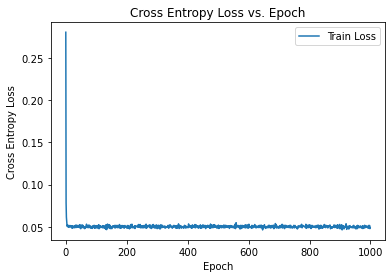

In [20]:
# Graficamos el error de entrenamiento

plt.plot(train_loss, label="Train Loss")
plt.legend(loc='best')
plt.title("Cross Entropy Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

In [21]:
predictions = softmax_clf.predict(X_test)

In [22]:
Acc = Accuracy()

In [23]:
Acc(y_test, predictions)

0.7565

### Graficamos la matriz de confusión

In [24]:
def getConfusionMatrix(truth, prediction, c):

    conf_mtx =[]
    
    for _ in range(c):
        conf_mtx.append([])
        for _ in range(c):
            conf_mtx[-1].append(0)

    for i in range(truth.shape[0]):
        conf_mtx[int(truth[i])][int(prediction[i])] += 1
    
    conf_mtx = np.array(conf_mtx)
    
    conf_mtx = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis]
    
    return conf_mtx

In [25]:
def plotConfusionMatrix(conf_mtx):    
    plt.imshow(conf_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(6)
    plt.xticks(tick_marks, np.arange(6) , rotation=45)
    plt.yticks(tick_marks, np.arange(6))

    fmt = '.2f'
    thresh = conf_mtx.max() / 2.

    for i, j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j, i, format(conf_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mtx[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [26]:
conf_mtx = getConfusionMatrix(y_test, predictions, 6)

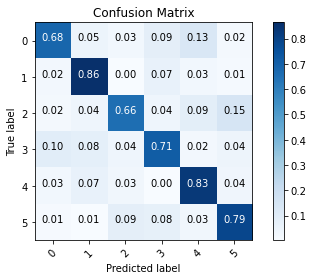

In [27]:
plotConfusionMatrix(conf_mtx)